In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from datasets import load_dataset 
from gensim.models import LdaModel
import matplotlib.pyplot as plt
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
#import nltk
#nltk.download('wordnet')
import numpy as np 
import torch
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pyLDAvis.gensim_models as gensimvis
from sklearn.metrics import davies_bouldin_score
import pyLDAvis
import pandas as pd

#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

def get_dataset(dataset_name, dataset_info_list):
    if isinstance(dataset_name,list):
        if dataset_name[0] == "tasksource/mmlu":
            try:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="test[0:100]", num_proc=8) 
            except:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="test", num_proc=8) 
        elif dataset_name[0] == "tasksource/bigbench":
            try:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="train[0:100]", num_proc=8) 
            except:
                traindata = load_dataset(dataset_name[0],dataset_name[1], split="train", num_proc=8) 
    else:
        if dataset_name == "EleutherAI/truthful_qa_mc":
            traindata = load_dataset(dataset_name, split="validation[0:100]", num_proc=8) 
        else:
            traindata = load_dataset(dataset_name, split="train[0:100]", num_proc=8) 
    if isinstance(dataset_name,list):
        key = dataset_info_list[dataset_name[0]]["keys"]
    else:
        key = dataset_info_list[dataset_name]["keys"]
    return traindata[key[0]]

def set_random_seed(seed=0):
    #random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_dataset_list(dataset_list):
    dataname = []
    for data in dataset_list:
        if "subset" not in dataset_list[data].keys():
            dataname.append(data)
        else:
            for subset in dataset_list[data]["subset"]:
                dataname.append([data,subset])
    return dataname

set_random_seed()

/home/bhandk/miniconda3/envs/MLNeuron/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
with open("/home/bhandk/MLNeuron/dataset_info.json", 'r') as openfile:
    # Reading from json file
    dataset_info_list = json.load(openfile)
dataset_name_list = get_dataset_list(dataset_info_list)
questions = []
questions_name = []
for dataset_name in dataset_name_list:
    data = get_dataset(dataset_name, dataset_info_list)
    questions.append(" ".join(data))
    if len(dataset_name) == 2:
        questions_name.append(dataset_name[-1])
    else:
        questions_name.append(dataset_name)

# Prepare Corpus and Dictionary

In [3]:

def tokenize_text(text):
    # Tokenize using NLTK
    tokens = word_tokenize(text)

    # Remove stopwords and perform stemming
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [ps.stem(token) for token in tokens if token.isalnum() not in stop_words]
    #tokens = [token for token in tokens if token.isalnum() not in stop_words]
    return tokens

In [4]:
#tokenizer = RegexpTokenizer(r'\w+')
import copy

new_copy = copy.deepcopy(questions)
for idx in range(len(questions)):
    new_copy[idx] = new_copy[idx].lower()  
    #new_copy[idx] = tokenizer.tokenize(new_copy[idx])  
    new_copy[idx] = tokenize_text(new_copy[idx])
# Remove numbers, but not words that contain numbers.
#questions = [[token for token in q if not token.isnumeric()] for q in questions]

# Remove words that are only one character.
#questions = [[token for token in q if len(token) > 1] for q in questions]

bigram = Phrases(new_copy, min_count=30)
for idx in range(len(new_copy)):
    for token in bigram[new_copy[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            new_copy[idx].append(token)

# Create a dictionary representation of the documents.
dictionary = Dictionary(new_copy)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.50)
corpus = [dictionary.doc2bow(q) for q in new_copy]

# LDA model

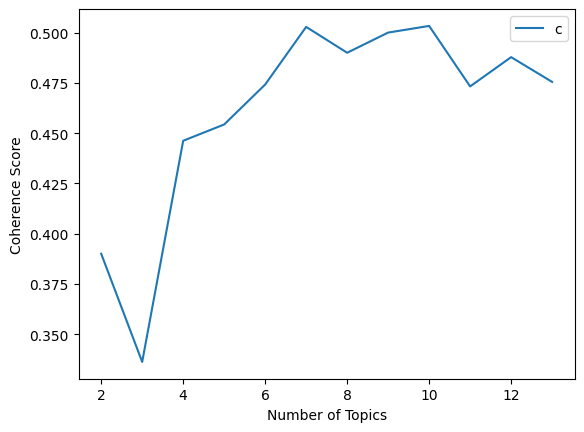

Optimal number of topics: 10


In [16]:
'''# Set training parameters.
num_topics = 20
#chunksize = 2000
passes = 500
iterations = 10000
#eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=passes,
    iterations=iterations,
    random_state = 0
)'''
# Function to compute coherence values for different number of topics
def compute_coherence_values(dictionary,texts, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    id2word = dictionary.id2token
    optimal_model = None
    best_coherece = 0
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            passes=500,
            iterations=10000,
            random_state=0
        )
        coherence_model = CoherenceModel(model=model,texts=texts,corpus=corpus,dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        if coherence_values[-1] > best_coherece:
            best_coherece = coherence_values[-1]
            optimal_model = model
    return optimal_model, coherence_values

# Set the range of topics to explore
start, limit, step = 2, 14, 1

# Get coherence values
model, coherence_values = compute_coherence_values(dictionary=dictionary,texts=new_copy, corpus=corpus, start=start, limit=limit, step=step)

# Plotting
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Find the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")


# Get Topics

TOPIC  1  count:  3
Topic Distribution:  [[(0, 0.9998641)], [(0, 0.1), (1, 0.1), (2, 0.1), (3, 0.1), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.1)], [(0, 0.5122933), (1, 0.019895641), (3, 0.45393145)]]
DATASET  ['key_value_maps' 'misconceptions_russian' 'moral_scenarios']
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TOPIC  2  count:  55
Topic Distribution:  [[(1, 0.43616176), (2, 0.30660778), (3, 0.16803956), (5, 0.08092006)], [(1, 0.41419762), (2, 0.2086719), (3, 0.23447159), (6, 0.016215814), (8, 0.12616722)], [(0, 0.011024195), (1, 0.3978109), (2, 0.15958364), (3, 0.38884637), (5, 0.03360283)], [(0, 0.010680472), (1, 0.48053625), (3, 0.0761591), (8, 0.4323714)], [(0, 0.017488252), (1, 0.6123031), (2, 0.052498948), (3, 0.24187952), (4, 0.011110792), (5, 0.022113755), (7, 0.041423015)], [(0, 0.0112197865), (1, 0.51859266), (3, 0.19408625), (4, 0.0277991), (6, 0.014727579), (7, 0.018822396), (8, 0.20508288)], [(1, 0.7

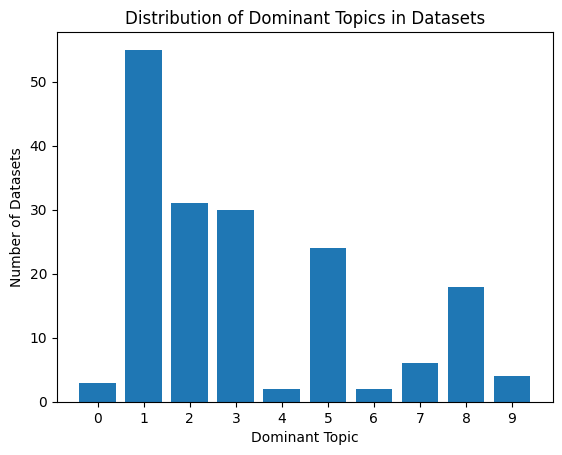

In [17]:

# Step 6: Assign Topics to Datasets.
topics = [model[doc] for doc in corpus]
dominant  = lambda x: max(x, key=lambda item: item[1])[0]
# Step 7: Categorize Datasets.
dominant_topic = np.array([dominant(t) for t in topics])
dominant_topic= dominant_topic.astype(int)
# Visualization (Optional):
# You can visualize the results using various libraries such as matplotlib or seaborn.
#print("Dominant Topic: ", len(dominant_topic) ,dominant_topic)
# Example: Bar chart of dominant topics
value, topic_index, topic_counts = np.unique(dominant_topic, return_index=True,return_counts=True)
plt.bar(value, topic_counts)
plt.xticks(value)
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Datasets')
plt.title('Distribution of Dominant Topics in Datasets')
plt.plot()
'''for index, topic in model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))'''
questions_name = np.array(questions_name)
for topic, count in zip(value,topic_counts):
    indexes = [i for i in range(len(dominant_topic)) if dominant_topic[i] == topic]
    print("TOPIC ",topic+1, " count: ", count)
    print("Topic Distribution: ", [topics[i] for i in indexes])
    print("DATASET ", questions_name[indexes])
    print("+"*100)
#plt.savefig("Test.png")

In [19]:


pyLDAvis.enable_notebook()
# Convert the gensim LDA model to a format compatible with pyLDAvis
vis_data = gensimvis.prepare(model, corpus,dictionary=dictionary,sort_topics=False)
#print(vis_data[1][vis_data[1]["Category"]!="Default"])
'''for term, freq, category,total in zip(vis_data[1]['Term'],vis_data[1]['Freq'],vis_data[1]["Category"],vis_data[1]["Total"]):
    if category != "Default":
        print(term, freq, category, total)'''
# Visualize the topics
pyLDAvis.display(vis_data)
#db_index_pca = davies_bouldin_score(vis_data[0]['x'], vis_data[0]['topics'])